# Webscraping from LA County COVID-19 Site and Creating Plot
- Patty Jula, <pattyjula@gmail.com>

LA County Public Health has been providing daily counts of the number of cases and rates Los Angeles County from COVID-19. This script provides a way to download the day's counts, load to a database, in this case a CSV, and create a plot. 

Source: <http://publichealth.lacounty.gov/media/Coronavirus/locations.htm>
## Note:
This type of webscraping is only available from sites that reveal their source code. The best practice is to ask permission before scraping so an organization's servers are not overloaded.

In [616]:
# Dependencies
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams

In [617]:
# Boilerplate code
url = 'http://publichealth.lacounty.gov/media/Coronavirus/locations.htm'
res = requests.get(url)
html_page = res.content

roundup_next_pow_10 = lambda x: 10**(
    int(np.log(x)/np.log(10)) + 1)

## Parse through the html

In [618]:
soup = BeautifulSoup(html_page, 'html.parser')
#print(soup.prettify())


## Load data to a Pandas dataframe

In [619]:
# column names
column = ['location', 'count', 'rate']

# empty list
data = []
count = 0
table = soup.find("table", {"table table-striped table-bordered table-sm"})#.findAll('tr')
for element in table.findAll("tr"):
    count += 1
    if count > 29: # first 29 rows are not needed
        # find cells containing td
        cells = element.findAll("td")
        info = [cell.text for cell in cells] # get the cell text
        data.append(info) # append to data list


In [620]:
df = pd.DataFrame(data, columns= column,) # convert to dataframe
df = df[df.rate != '--'] # drop select records
#df.to_csv("county.csv", encoding='utf-8', index=False)

In [621]:
# handle empty cells, they are not read as NaN by default
df['rate'].replace('', np.nan, inplace=True)
# now they can be deleted
df.dropna(subset=['rate'], inplace=True)

In [622]:
df.to_csv("county.csv", encoding='utf-8', index=False)
df = pd.read_csv('county.csv', index_col=False)
#df.to_csv("county.csv", encoding='utf-8', index=False)
df=df[df['location'].apply(lambda x: x.startswith('Los Angeles -'))]
df.rate.astype(float)
df = df.sort_values(by='rate',ascending=False)

df.head(10)

,location,count,rate
114,Los Angeles - Hancock Park,37,225.27
83,Los Angeles - Beverly Crest,24,193.63
82,Los Angeles - Bel Air,15,182.53
89,Los Angeles - Carthay,24,178.86
98,Los Angeles - Crestview,20,174.73
91,Los Angeles - Century City,21,173.38
136,Los Angeles - Melrose,129,166.16
158,Los Angeles - South Carthay,17,160.44
131,Los Angeles - Little Armenia,12,158.52
86,Los Angeles - Brentwood,46,147.12


## Add today's date to the dataframe

In [623]:
import datetime
def today_date():
    '''
    utils:
    get the datetime of today
    '''
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
df['Date'] = today_date()

## foo

# bar

## Explicitly convert Dat field to date

In [624]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df2['count'] = d2['count'].str.replace(',', '').astype(int)
df['location'] = df.location.str[14:]
df.head() 

,location,count,rate,Date
114,Hancock Park,37,225.27,2020-04-04
83,Beverly Crest,24,193.63,2020-04-04
82,Bel Air,15,182.53,2020-04-04
89,Carthay,24,178.86,2020-04-04
98,Crestview,20,174.73,2020-04-04


In [625]:
df.to_csv("nbhrd_temp.csv", encoding='utf-8', index=False)

## Now let's deal with the existing database

### This existing database contains previous day's data

In [626]:
dfDB = pd.read_csv("neighborhood_storage.csv", parse_dates=['Date'], dayfirst=True)
#dfDB.set_index('Date')
#dfDB.head()

## If current day's date is already in database, delete it

In [627]:
for index, row in dfDB.iterrows():
    #print(row['Date'])
    if row['Date'] == today_date():
        #print('Found')
        dfDB.drop(index, inplace=True)
    else:
        pass

## Then let's add the newly scraped data to the database

In [628]:
df= dfDB.append(df, ignore_index = True,sort=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.sort_values(by='Date',ascending=True)
#del df['Unnamed: 0']
#df['Date'] = pd.to_datetime(df['Date']).dt.date
print('rate: per 100,000')
df.head(20)

rate: per 100,000


,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73
5,2020-04-04,21,Century City,173.38
6,2020-04-04,129,Melrose,166.16
7,2020-04-04,17,South Carthay,160.44
8,2020-04-04,12,Little Armenia,158.52
9,2020-04-04,46,Brentwood,147.12


In [629]:


df.to_csv("neighborhood_storage.csv", encoding='utf-8', index=False)
df.head()

,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73


## Again, explicitly set date

In [630]:
#df['Date'] = df["Date"].apply(pd.to_datetime,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.nlargest(10, 'rate')

# Create plot with seaborn

/home/patty/anaconda3/envs/ds-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


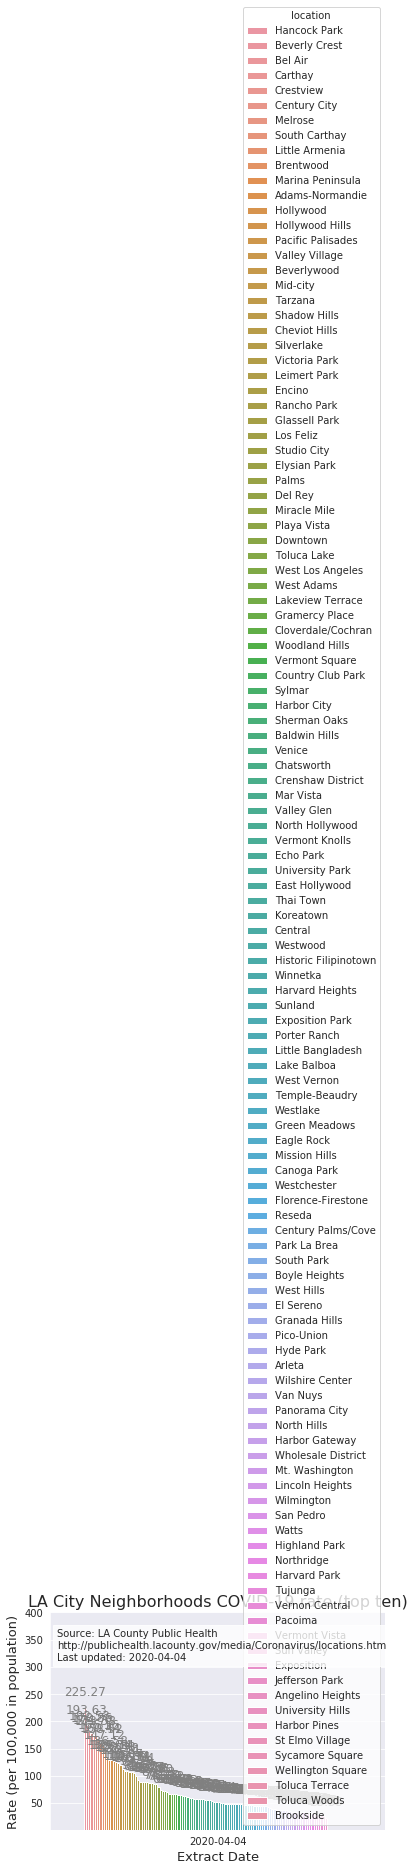

In [631]:
#sns.set(style="whitegrid")
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(x="Date", y="rate", hue= 'location', data=df)#,hue_order=pd.value_counts(df['rate']).iloc[:10])#, palette ="bright")#, color= 'Set2')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# Annotate bars
for p in ax.patches:
    #y = int("count")
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', fontsize=12, color='gray', xytext=(0, 15),
        textcoords='offset points')
#sns.set_ylabels("") 
plt.xlabel("Extract Date", size = 13)
plt.ylabel("Rate (per 100,000 in population)", size = 13)
#plt.yscale('log')
plt.title("LA City Neighborhoods COVID-19 rate (top ten)", size = 16)
# bar lot
plt.ylim(1,400)
plt.tight_layout()
source_txt = """Source: LA County Public Health
http://publichealth.lacounty.gov/media/Coronavirus/locations.htm
Last updated: """
last_date = df["Date"].max()
source_txt += last_date.strftime("%Y-%m-%d")
plt.figtext(0.02, 0.78, source_txt,transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))
, horizontalalignment='right') 
plt.savefig('neighborhood.png', dpi=400) 
plt.show()

In [632]:
import geopandas
#url = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-current.geojson"
gdf = geopandas.read_file("neighborhood.geojson")

In [633]:
#pip install geopandas
#gdf.to_csv("neighborhoods.csv")
gdf.head(20)


,name,slug,geometry
0,Adams-Normandie,adams-normandie,"MULTIPOLYGON (((-118.30901 34.03741, -118.3057..."
1,Arleta,arleta,"MULTIPOLYGON (((-118.42202 34.22410, -118.4228..."
2,Arlington Heights,arlington-heights,"MULTIPOLYGON (((-118.31591 34.05261, -118.3155..."
3,Atwater Village,atwater-village,"MULTIPOLYGON (((-118.27832 34.15301, -118.2783..."
4,Baldwin Hills/Crenshaw,baldwin-hillscrenshaw,"MULTIPOLYGON (((-118.35626 34.02484, -118.3550..."
5,Bel-Air,bel-air,"MULTIPOLYGON (((-118.46901 34.12951, -118.4674..."
6,Beverly Crest,beverly-crest,"MULTIPOLYGON (((-118.45321 34.13181, -118.4512..."
7,Beverly Grove,beverly-grove,"MULTIPOLYGON (((-118.37249 34.08575, -118.3724..."
8,Beverlywood,beverlywood,"MULTIPOLYGON (((-118.38961 34.05231, -118.3896..."
9,Boyle Heights,boyle-heights,"MULTIPOLYGON (((-118.19271 34.06181, -118.1927..."


In [634]:
#gdf.plot();
gdfNew = gdf.merge(df, left_on='name', right_on='location', how='inner')


In [643]:
gdfNew[["Date"]] = gdfNew[["Date"]].astype(str) 

In [644]:
#gdf.crs = "EPSG:4326"
gdfNew.head(10)

,name,slug,geometry,Date,count,location,rate
0,Adams-Normandie,adams-normandie,"MULTIPOLYGON (((-118.30901 34.03741, -118.3057...",2020-04-04,11,Adams-Normandie,129.61
1,Arleta,arleta,"MULTIPOLYGON (((-118.42202 34.22410, -118.4228...",2020-04-04,13,Arleta,37.03
2,Beverly Crest,beverly-crest,"MULTIPOLYGON (((-118.45321 34.13181, -118.4512...",2020-04-04,24,Beverly Crest,193.63
3,Beverlywood,beverlywood,"MULTIPOLYGON (((-118.38961 34.05231, -118.3896...",2020-04-04,16,Beverlywood,120.11
4,Boyle Heights,boyle-heights,"MULTIPOLYGON (((-118.19271 34.06181, -118.1927...",2020-04-04,36,Boyle Heights,41.26
5,Brentwood,brentwood,"MULTIPOLYGON (((-118.48842 34.13001, -118.4880...",2020-04-04,46,Brentwood,147.12
6,Canoga Park,canoga-park,"MULTIPOLYGON (((-118.60302 34.23531, -118.6017...",2020-04-04,29,Canoga Park,45.53
7,Carthay,carthay,"MULTIPOLYGON (((-118.36841 34.06371, -118.3656...",2020-04-04,24,Carthay,178.86
8,Century City,century-city,"MULTIPOLYGON (((-118.41443 34.06444, -118.4143...",2020-04-04,21,Century City,173.38
9,Chatsworth,chatsworth,"MULTIPOLYGON (((-118.58509 34.30348, -118.5800...",2020-04-04,21,Chatsworth,58.27


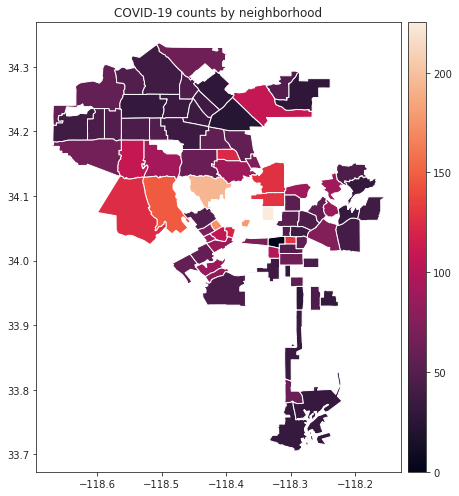

In [645]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#sns.set_style('darkgrid')
#fig, ax = plt.subplots()
#rcParams['figure.figsize'] = 11.7,8.27

fig, ax = plt.subplots(1, 1)
plt.title('COVID-19 counts by neighborhood')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdfNew.plot(column='rate', ax=ax, legend=True, cax=cax)

In [646]:
gdfNew.to_file(driver = 'ESRI Shapefile', filename= 'nghbrhddata.shp')